In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.dataset.repository.datasets import dataset_recipes

from time_blend import TimeBlendEstimator

Setting ds_accelerator to cuda (auto detect)


## Prepeare data set

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [5]:
train_grouper = MultivariateGrouper(
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality)
)

test_grouper = MultivariateGrouper(
    num_test_dates=int(len(dataset.test) / len(dataset.train)),
    max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality),
)

In [6]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

## Evaluator

In [7]:
evaluator = MultivariateEvaluator(
    quantiles=(np.arange(20) / 20.0)[1:], target_agg_funcs={"sum": np.sum}
)

## ` TimeBlend-RNN`

In [8]:
estimator = TimeBlendEstimator(
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=3,
    dropout_rate=0.1,
    lags_seq=[1, 24 * 7],

    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling="std",
    trainer_kwargs=dict(max_epochs=100, accelerator="gpu", devices="1"),
)

In [9]:
predictor = estimator.train(dataset_train, cache_data=True)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Ty

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 4988.88965 (best 4988.88965), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_100/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 2351.23193 (best 2351.23193), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_100/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 1434.51440 (best 1434.51440), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_100/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 255.60728 (best 255.60728), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_100/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 33.11868 (best 33.11868), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_100/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 't

In [45]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset_test, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))


Running evaluation: 7it [00:00, 110.01it/s]

Running evaluation: 7it [00:00, 110.74it/s]

Running evaluation: 7it [00:00, 108.49it/s]

Running evaluation: 7it [00:00, 110.22it/s]

Running evaluation: 7it [00:00, 110.44it/s]

Running evaluation: 7it [00:00, 110.44it/s]

Running evaluation: 7it [00:00, 108.53it/s]

Running evaluation: 7it [00:00, 109.92it/s]

Running evaluation: 7it [00:00, 109.86it/s]

Running evaluation: 7it [00:00, 109.44it/s]

Running evaluation: 7it [00:00, 109.46it/s]

Running evaluation: 7it [00:00, 112.09it/s]

Running evaluation: 7it [00:00, 112.87it/s]

Running evaluation: 7it [00:00, 111.94it/s]

Running evaluation: 7it [00:00, 111.15it/s]

Running evaluation: 7it [00:00, 110.83it/s]

Running evaluation: 7it [00:00, 110.69it/s]

Running evaluation: 7it [00:00, 110.68it/s]

Running evaluation: 7it [00:00, 110.59it/s]

Running evaluation: 7it [00:00, 110.44it/s]

Running evaluation: 7it [00:00, 110.21it/s]

Running evaluation: 7it [00:00, 110.03it/s]

Running e

### Metrics

In [46]:
print("CRPS: {}".format(agg_metric["mean_wQuantileLoss"]))
print("ND: {}".format(agg_metric["ND"]))
print("NRMSE: {}".format(agg_metric["NRMSE"]))
print("MSE: {}".format(agg_metric["MSE"]))

CRPS: 0.4528612943995278
ND: 0.508780935729714
NRMSE: 1.0405103043843094
MSE: 1027.0002714189588


In [47]:
print("CRPS-Sum: {}".format(agg_metric["m_sum_mean_wQuantileLoss"]))
print("ND-Sum: {}".format(agg_metric["m_sum_ND"]))
print("NRMSE-Sum: {}".format(agg_metric["m_sum_NRMSE"]))
print("MSE-Sum: {}".format(agg_metric["m_sum_MSE"]))

CRPS-Sum: 0.41221889148246915
ND-Sum: 0.4427701797516869
NRMSE-Sum: 0.8360538995847802
MSE-Sum: 12444787.833333332


In [48]:
def plot(
    target,
    forecast,
    prediction_length,
    prediction_intervals=(50.0, 90.0),
    color="g",
    fname=None,
):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape

    ps = [50.0] + [
        50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
    ]

    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)

        ps_data = [forecast.quantile(p / 100.0)[:, dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2

        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)

        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]
    axx[0].legend(legend, loc="upper left")

    if fname is not None:
        plt.savefig(fname, bbox_inches="tight", pad_inches=0.05)

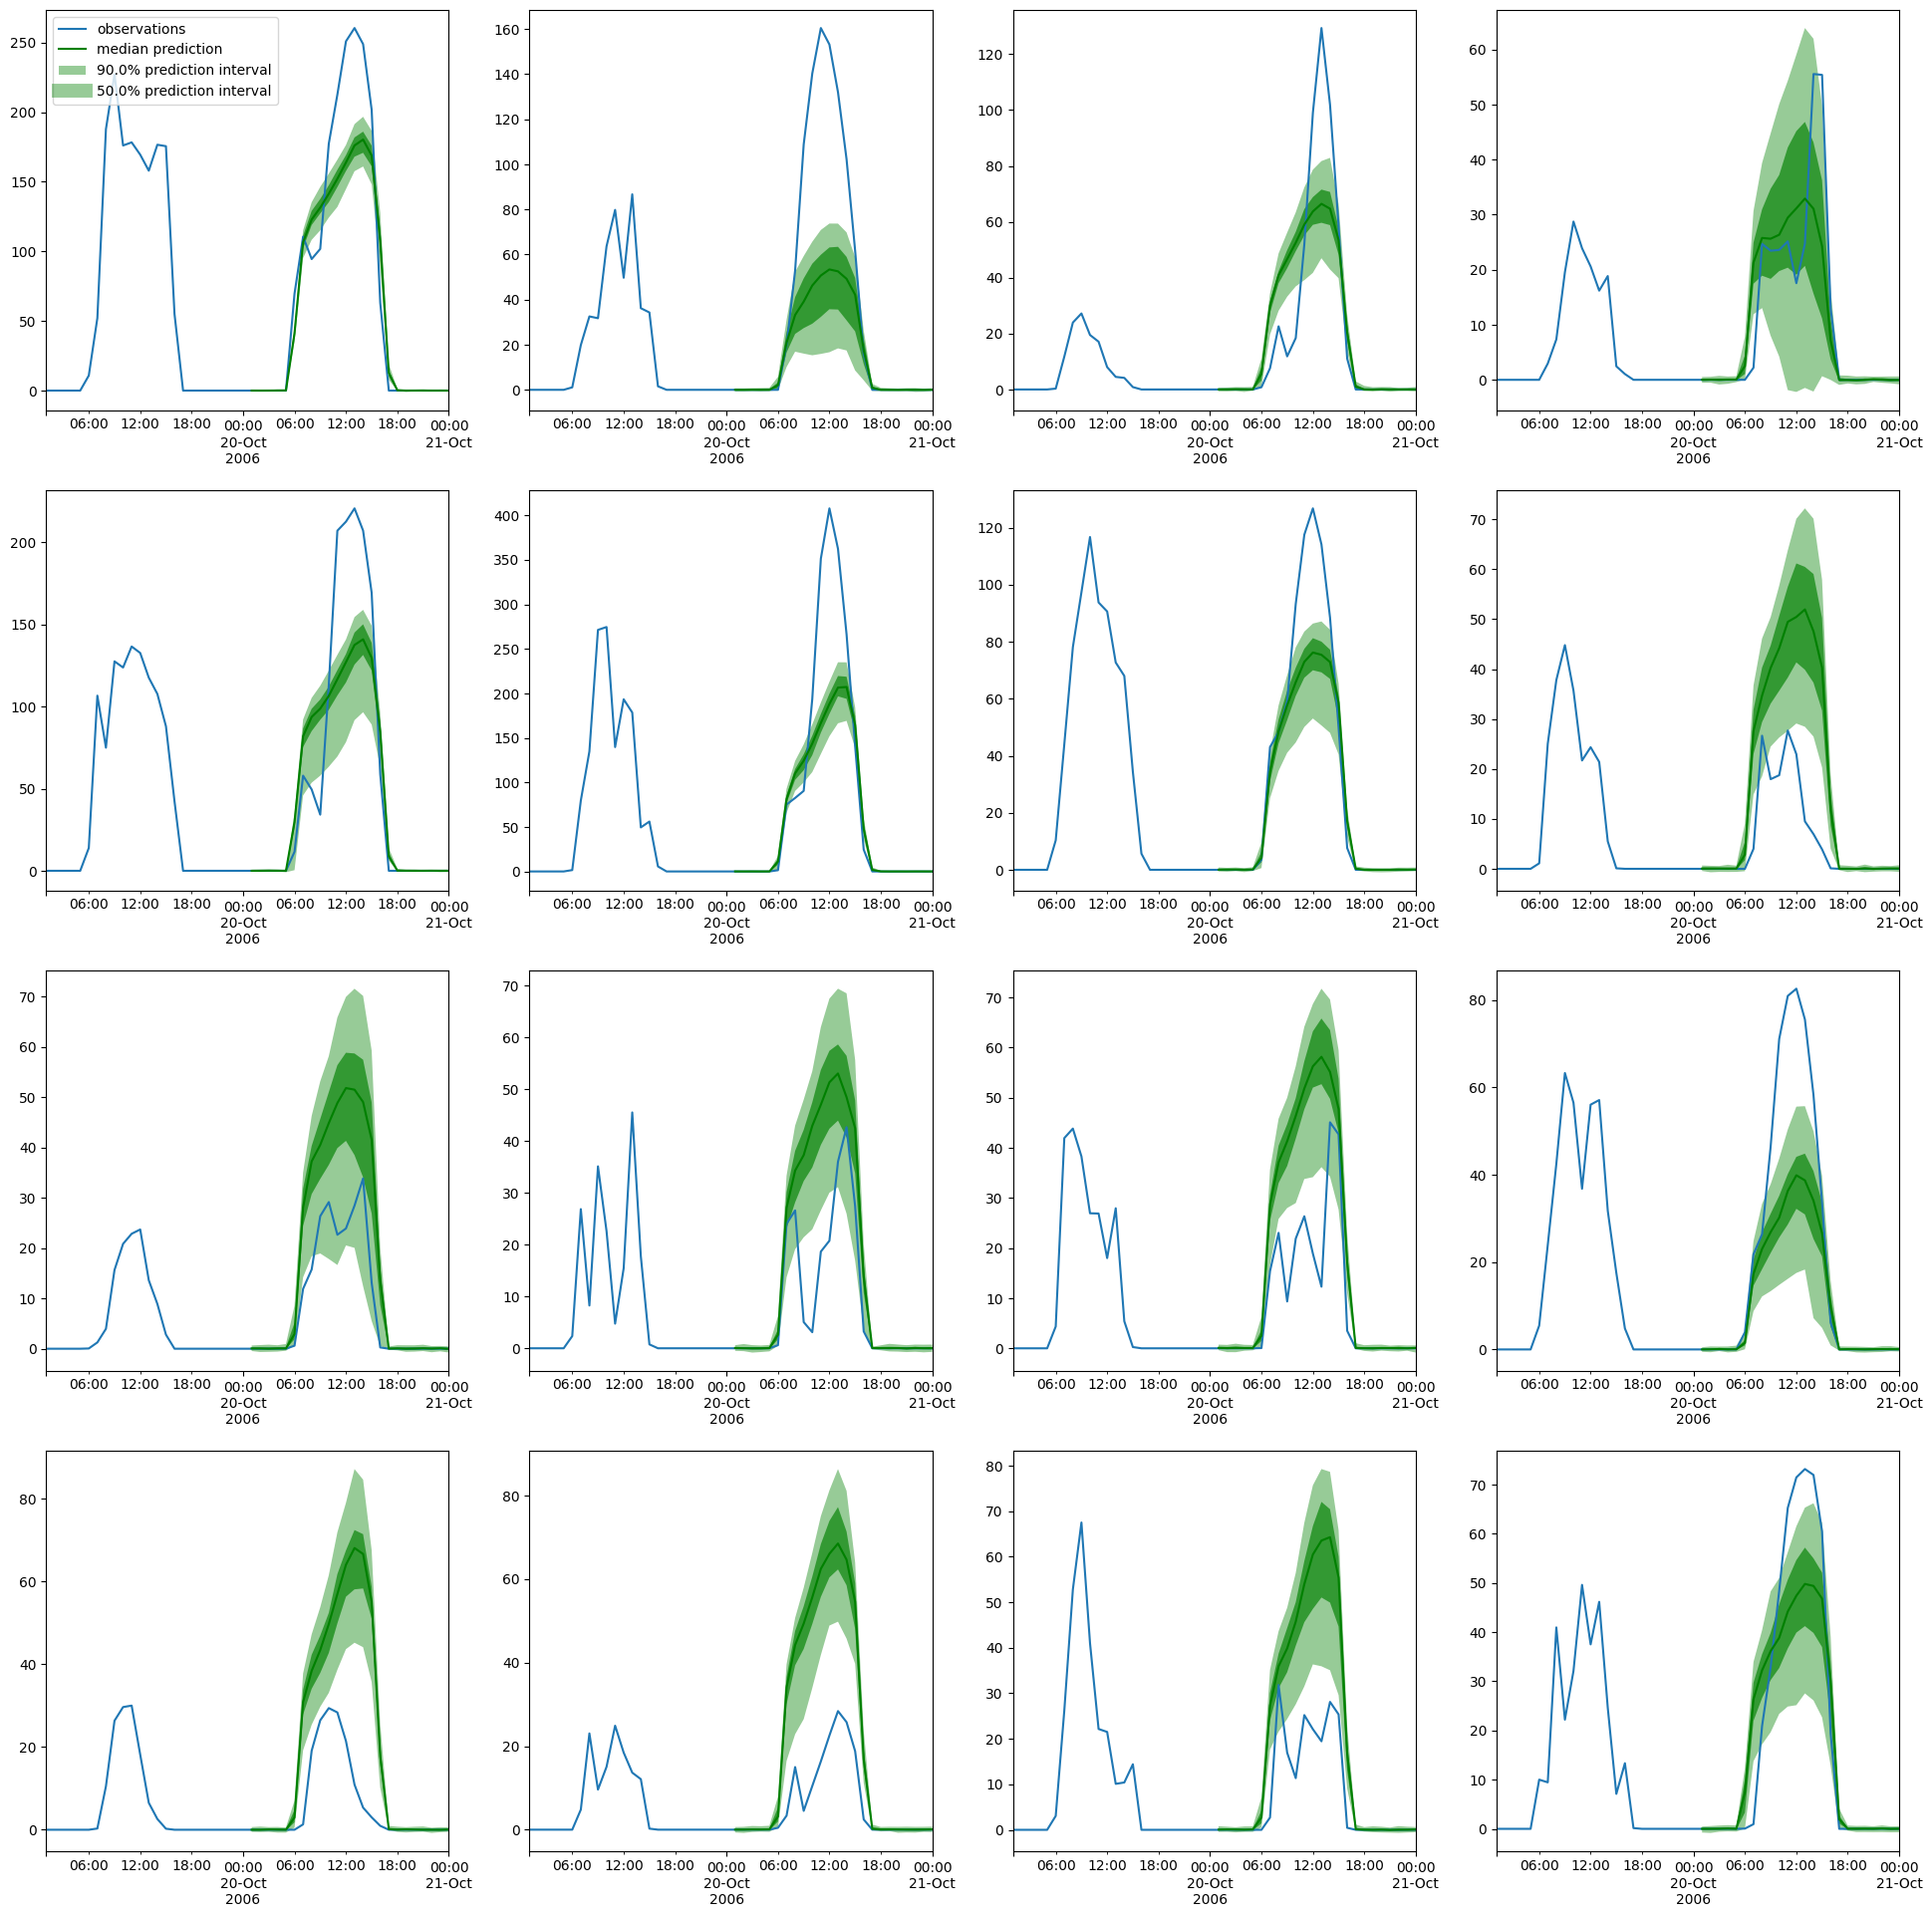

[rank: 0] Received SIGTERM: 15
[rank: 0] Received SIGTERM: 15


In [49]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()